# Imports

In [189]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifierLib
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifierLib
from sklearn.ensemble import GradientBoostingClassifier

# Functions

In [71]:
class Vertex:
    def __init__(
            self,
            feature=None,
            threshold=None,
            metric=None,
            left=None,
            right=None,
            value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.metric = metric
        self.value = value

In [72]:
class DecisionTree:
    def __init__(
            self,
            min_samples_split=2,
            max_depth=5,
            min_samples_leaf=10,
            max_features=20
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features

        self.tree_depth = 0
        self.root = None
        self.X_train = None
        self.y_train = None

    # IGain
    @staticmethod
    def calc_metric(parent, left, right):
        def entropy(y):
            res = 0
            classes = np.unique(y)
            for cl in classes:
                pl = len(y[y == cl]) / len(y)
                res -= pl * np.log2(pl)
            return res

        s_entropy = entropy(parent)
        s_left_s = len(left) / len(parent)
        s_right_s = len(right) / len(parent)
        weighted_entropy = s_left_s * entropy(left) + s_right_s * entropy(right)
        return s_entropy - weighted_entropy

    def define_node(self, data, num_features):
        sample_vertex = Vertex(metric=-1)
        for f_id in range(num_features):
            thresholds = np.unique(data[:, f_id])
            for th in thresholds:
                left = []
                right = []
                for row in data:
                    if row[f_id] <= th:
                        left.append(row)
                    else:
                        right.append(row)
                left, right = np.array(left), np.array(right)

                if len(left) >= self.min_samples_leaf and len(right) >= self.min_samples_leaf:
                    i_gain = self.calc_metric(data[:, -1], left[:, -1], right[:, -1])
                    if i_gain > sample_vertex.metric:
                        sample_vertex = Vertex(f_id, th, i_gain, left, right)

        if sample_vertex.metric > 0:
            return sample_vertex
        else:
            return None

    def build(self, data, current_depth=0):
        n_samples, n_features = data[:, :-1].shape
        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:

            if n_features > self.max_features:
                n_features = self.max_features

            new_node = self.define_node(data, n_features)

            if new_node is not None:
                left = self.build(new_node.left, current_depth + 1)
                right = self.build(new_node.right, current_depth + 1)
                return Vertex(new_node.feature, new_node.threshold, new_node.metric, left, right)

        if current_depth > self.tree_depth:
            self.tree_depth = current_depth

        vals = data[:, -1]
        return Vertex(value=max(list(vals), key=list(vals).count))


    def fit(self, X_y_train):
        self.X_train = X_y_train[:, :-1]
        self.y_train = X_y_train[:, -1]
        self.root = self.build(X_y_train)

    def predict(self, X_test):
        return np.array([self.decision_function(i, self.root) for i in X_test])

    def decision_function(self, x, vertex):
        if vertex.value is None:
            if x[vertex.feature] <= vertex.threshold:
                return self.decision_function(x, vertex.left)
            else:
                return self.decision_function(x, vertex.right)
        else:
            return vertex.value

    def get_train_score(self):
        y_pred_train = self.predict(self.X_train)
        return accuracy_score(self.y_train, y_pred_train)

    def get_test_score(self, X_test, y_test):
        y_pred_train = self.predict(X_test)
        return accuracy_score(y_test, y_pred_train)


In [176]:
class RandomForest:
    def __init__(
            self,
            n_estimators=100,
            min_samples_split=2,
            max_depth=3,
            min_samples_leaf=10,
            batch_size=100
    ):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.batch_size = batch_size

        self.max_features = 0
        self.n_features = 0
        self.trees = []
        self.X_train = None
        self.y_train = None


    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        np.random.seed(1)
        n_samples = self.X_train.shape[0]
        self.n_features = self.X_train.shape[1]
        self.max_features = int(np.sqrt(self.X_train.shape[1]))
        for _ in range(self.n_estimators):

            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features
            )
            ids_row = np.random.choice(n_samples, self.batch_size, replace=True)
            ids_cols = np.random.choice(self.n_features, self.max_features, replace=True)

            batch = self.take_features(self.X_train[ids_row], ids_cols)
            tree.fit(np.concatenate((batch, y_train[ids_row]), axis=1))
            self.trees.append({"tree": tree, "cols": ids_cols})

    @staticmethod
    def take_features(data, cols):
        to_concat = ()
        for col in cols:
            to_add = data[:, col].reshape(-1, 1)
            to_concat = to_concat + (to_add,)
        return np.concatenate(to_concat, axis=1)

    def predict(self, X_test):
        full_votes = np.array(
            [
                algo.get("tree").predict(
                    self.take_features(X_test, algo.get("cols"))
                ) for algo in self.trees
            ]
        )

        full_votes = np.swapaxes(full_votes, 0, 1)
        return np.array([max(list(vote), key=list(vote).count) for vote in full_votes])

    def get_train_score(self):
        y_pred_train = self.predict(self.X_train)
        return accuracy_score(self.y_train, y_pred_train)

    def get_test_score(self, X_test, y_test):
        y_pred_train = self.predict(X_test)
        return accuracy_score(y_test, y_pred_train)


In [74]:
class GradientBoosting():
    def __init__(
            self,
            n_estimators = 10,
            learning_rate = 0.01,
            min_samples_split=10,
            max_depth=2,
            min_samples_leaf=10,
            max_features=20
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features

        self.X_train = None
        self.y_train = None
        self.trees = []

        for _ in range(n_estimators):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features
            )
            self.trees.append(tree)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        initial_vals = np.full(np.shape(self.y_train), np.mean(self.y_train, axis=0))
        self.trees[0].fit(np.concatenate((self.X_train, initial_vals), axis=1))
        y_pred = self.trees[0].predict(self.X_train)
        for t in range(1, self.n_estimators):
            gradient = self.calculate_loss(self.y_train, y_pred)
            self.trees[t].fit(np.concatenate((self.X_train, gradient), axis=1))
            at = self.trees[t].predict(self.X_train)
            y_pred -= np.multiply(self.learning_rate, at)

    @staticmethod
    def calculate_loss(y, p):
        p = np.clip(p, 1e-12, 1 - 1e-12)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def predict(self, X):
        y_pred = np.array([])
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = update if not y_pred.any() else update - y_pred
        return np.sign(y_pred)

    def get_train_score(self):
        y_pred_train = self.predict(self.X_train)
        return accuracy_score(self.y_train, y_pred_train)

    def get_test_score(self, X_test, y_test):
        y_pred_train = self.predict(X_test)
        return accuracy_score(y_test, y_pred_train)

In [75]:
def MinMax(foo):
    cols_n = foo.shape[1]
    for i in range(cols_n):
        v = foo[:, i]
        foo[:, i] = (v - v.min()) / (v.max() - v.min())
    return foo

In [ ]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# график зависимости высоты дерева

In [160]:
def make_stat(func, param_list, param_name, is_lib):
    paramr = {}
    if is_lib:
        paramr["random_state"] = 0
    else:
        paramr["max_depth"] = 200
    stat_list = []
    for mss in param_list:
        paramr[param_name] = mss
        clf = func(**paramr)
        if is_lib:
            clf.fit(X_train, y_train)
        else:
            clf.fit(np.concatenate((X_train, y_train), axis=1))
        y_pred_train = clf.predict(X_train)
        train = accuracy_score(y_train, y_pred_train)
        y_pred_test = clf.predict(X_test)
        test = accuracy_score(y_test, y_pred_test)
        if is_lib:
            depth = clf.get_depth()
        else:
            depth = clf.tree_depth
        stat_list.append([param_name, mss, depth, train, test])
    return stat_list

In [161]:
def graph_stat(func, is_lib):
    min_samples_split_list = range(2, 200, 5)
    min_samples_leaf_list = range(1, 100, 5)
    max_features_list = range(2, X_train.shape[1])
    big_stat_list = []
    big_stat_list.extend(make_stat(func, min_samples_split_list, "min_samples_split", is_lib))
    big_stat_list.extend(make_stat(func, min_samples_leaf_list, "min_samples_leaf", is_lib))
    big_stat_list.extend(make_stat(func, max_features_list, "max_features", is_lib))
    stat_df = pd.DataFrame(big_stat_list, columns=["param", "val", "depth", "accuracy_train", "accuracy_test"])

    mss = stat_df[stat_df['param'] == "min_samples_split"]
    fig6, ax_arr = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

    mss = stat_df[stat_df['param'] == "min_samples_split"]
    ax_arr[0].set_title("min_samples_split")
    sns.lineplot(data=mss, x="val", y="depth", ax=ax_arr[0]).set(xlabel=None)

    mss = stat_df[stat_df['param'] == "min_samples_leaf"]
    ax_arr[1].set_title("min_samples_leaf")
    sns.lineplot(data=mss, x="val", y="depth", ax=ax_arr[1]).set(ylabel=None)

    mss = stat_df[stat_df['param'] == "max_features"]
    ax_arr[2].set_title("max_features")
    g = sns.lineplot(data=mss, x="val", y="depth", ax=ax_arr[2])
    g.set(xlabel=None)
    g.set(ylabel=None)
    plt.show()
    return stat_df

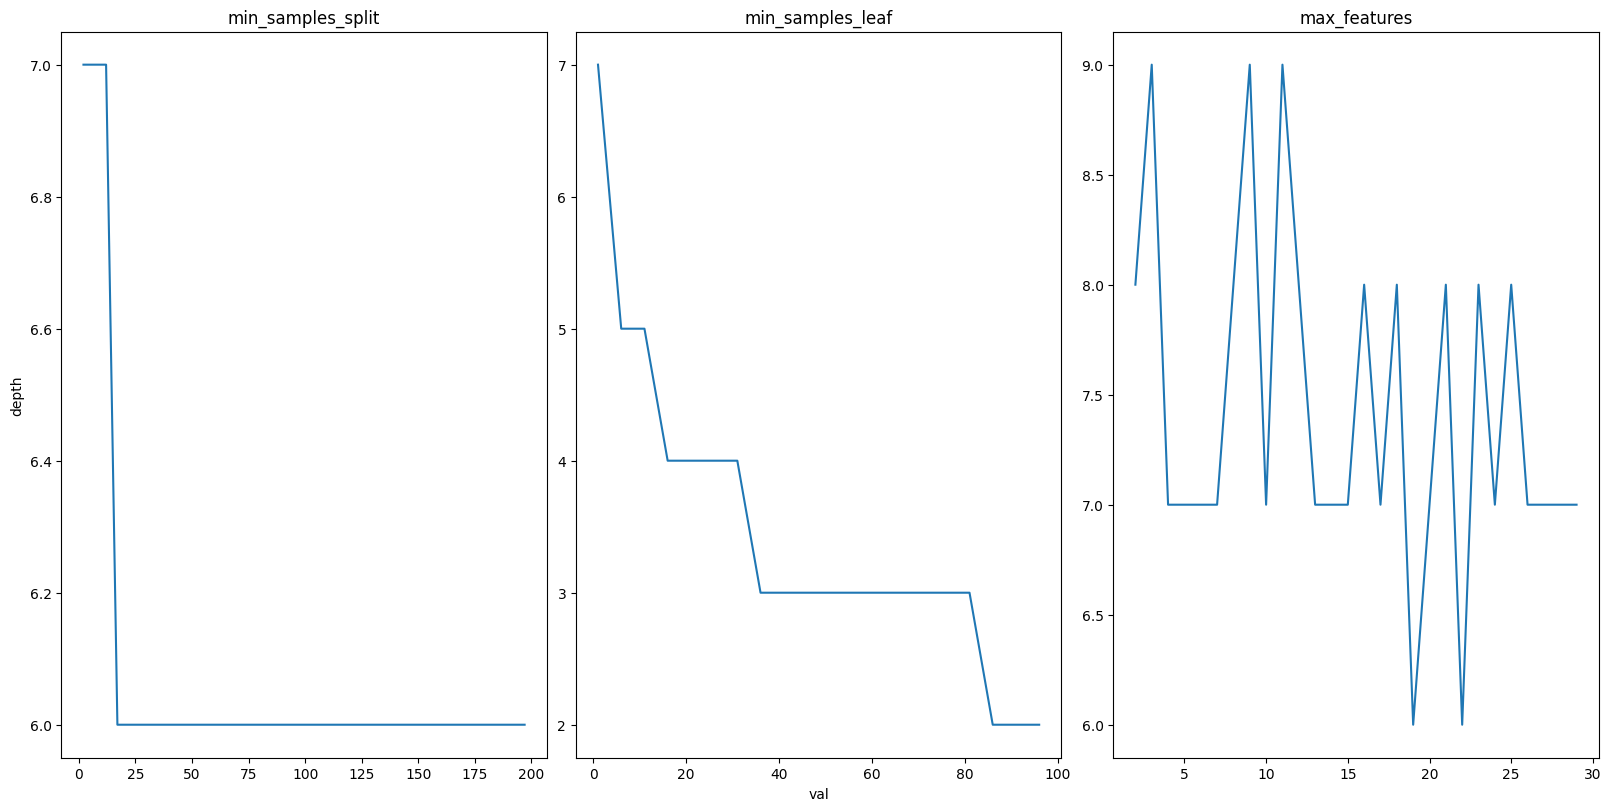

In [162]:
st_lib = graph_stat(DecisionTreeClassifierLib, True)

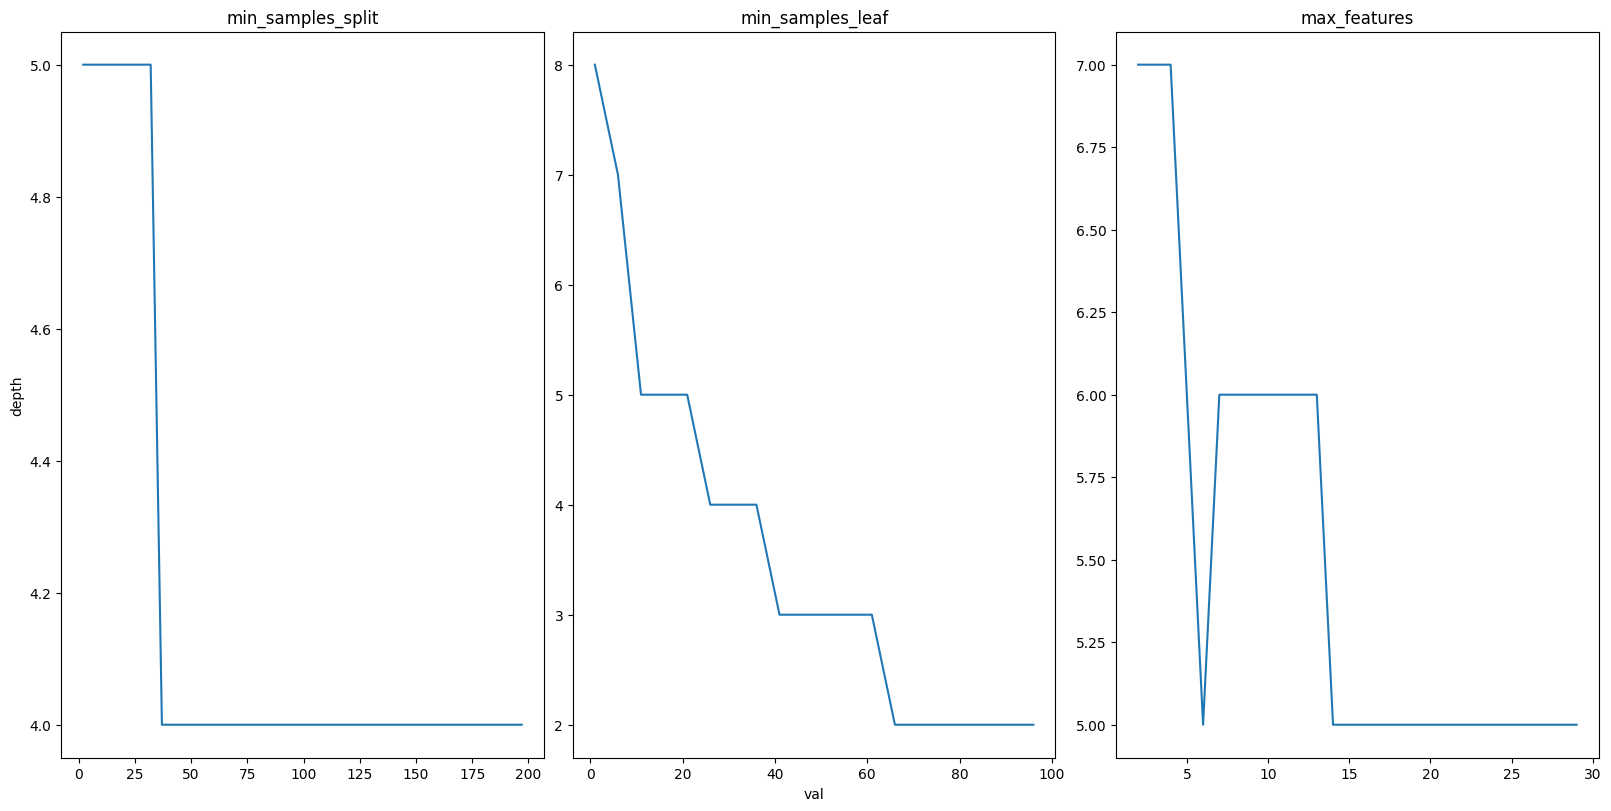

In [163]:
st_my = graph_stat(DecisionTree, False)

# график зависимости целевой функции ошибки от высоты дерева

In [169]:
max_depth_list = range(1, 15)

depth_stat = []
for d in max_depth_list:
    clf = DecisionTreeClassifierLib(max_depth=d)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    train = accuracy_score(y_train, y_pred_train)
    y_pred_test = clf.predict(X_test)
    test = accuracy_score(y_test, y_pred_test)
    depth_stat.append([d, train, test])

depth_stat_lib = pd.DataFrame(depth_stat, columns=["max_depth", "train_accuracy", "test_accuracy"])

depth_stat = []
for d in max_depth_list:
    clf = DecisionTree(max_depth=d)
    clf.fit(np.concatenate((X_train, y_train), axis=1))
    y_pred_train = clf.predict(X_train)
    train = accuracy_score(y_train, y_pred_train)
    y_pred_test = clf.predict(X_test)
    test = accuracy_score(y_test, y_pred_test)
    depth_stat.append([d, train, test])

depth_stat_my = pd.DataFrame(depth_stat, columns=["max_depth", "train_accuracy", "test_accuracy"])

[Text(0, 0.5, '')]

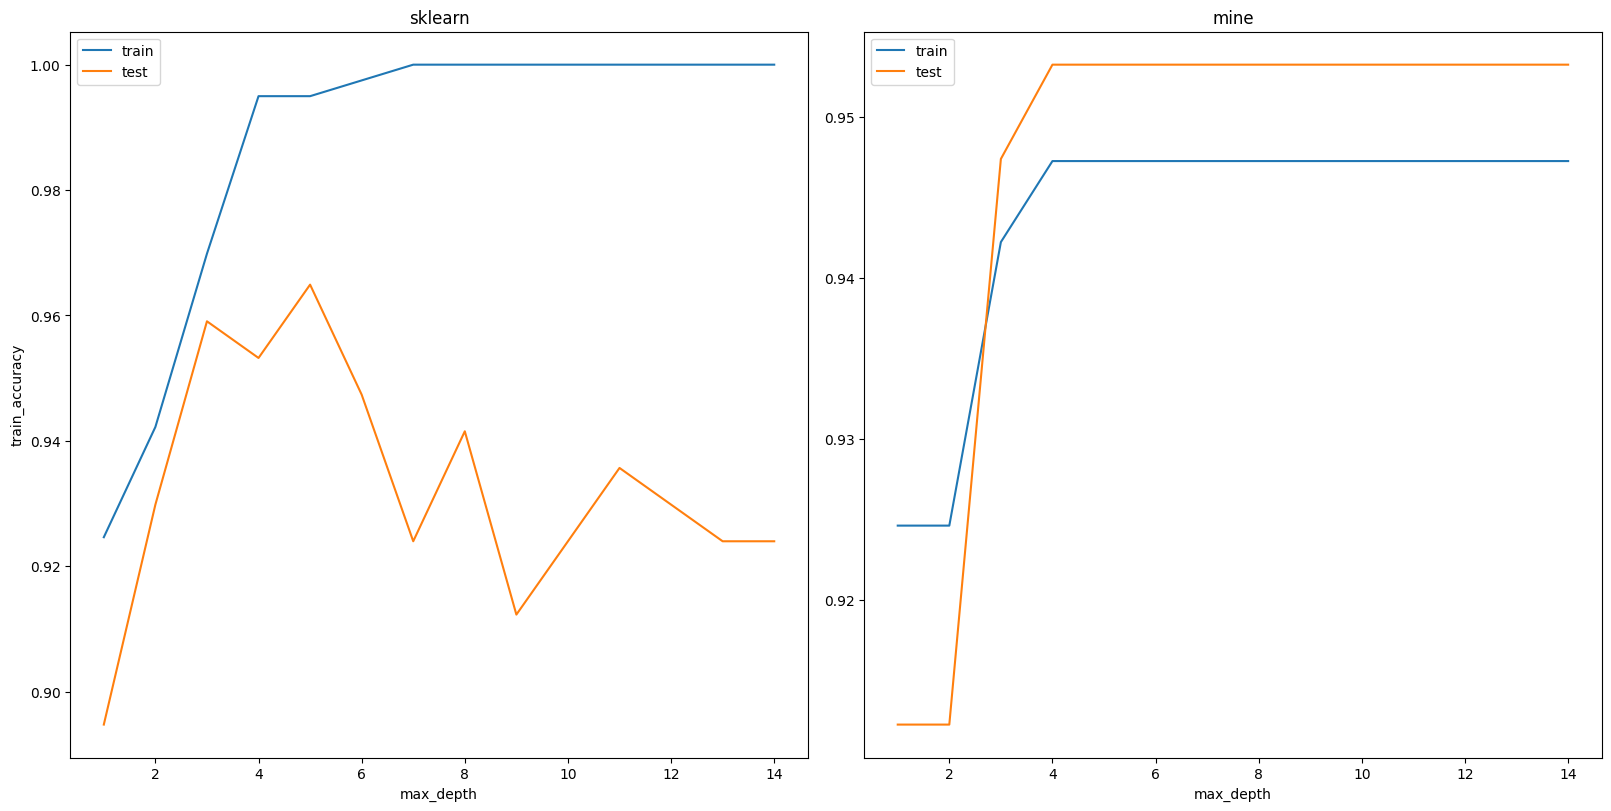

In [175]:
fig6, ax_arr = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

ax_arr[0].set_title("sklearn")
sns.lineplot(data=depth_stat_lib, x="max_depth", y="train_accuracy", ax=ax_arr[0], label="train")
sns.lineplot(data=depth_stat_lib, x="max_depth", y="test_accuracy", ax=ax_arr[0], label="test")

ax_arr[1].set_title("mine")
sns.lineplot(data=depth_stat_my, x="max_depth", y="train_accuracy", ax=ax_arr[1], label="train").set(ylabel=None)
sns.lineplot(data=depth_stat_my, x="max_depth", y="test_accuracy", ax=ax_arr[1], label="test").set(ylabel=None)


# график зависимости функцию ошибки от числа деревьев на тренировочном и тестовом множестве для случайного леса

In [188]:
def forest_stat(func, n_estimators):
    n_estimators_stat = []
    for d in n_estimators:
        clf = func(n_estimators=d)
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        train = accuracy_score(y_train, y_pred_train)
        y_pred_test = clf.predict(X_test)
        test = accuracy_score(y_test, y_pred_test)
        n_estimators_stat.append([d, train, test])
    n_estimators_stat_lib = pd.DataFrame(n_estimators_stat, columns=["n_estimators", "train_accuracy", "test_accuracy"])
    return n_estimators_stat_lib

In [ ]:
n_estimators = range(1, 500, 20)
stat_lib = forest_stat(RandomForestClassifierLib, n_estimators)
stat_my = forest_stat(RandomForest, n_estimators)

[Text(0, 0.5, '')]

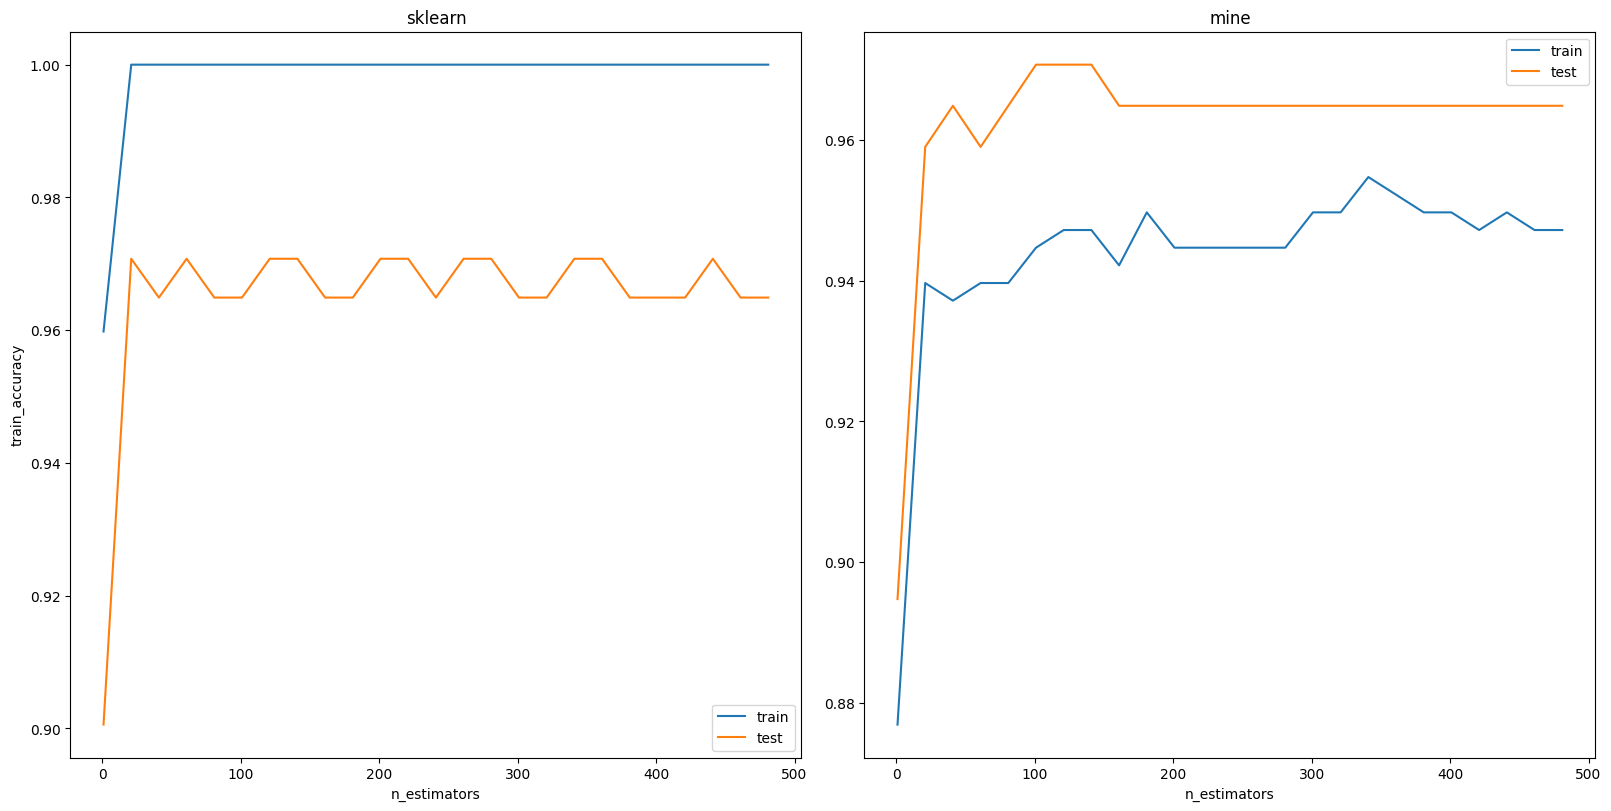

In [187]:
fig6, ax_arr = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

ax_arr[0].set_title("sklearn")
sns.lineplot(data=stat_lib, x="n_estimators", y="train_accuracy", ax=ax_arr[0], label="train")
sns.lineplot(data=stat_lib, x="n_estimators", y="test_accuracy", ax=ax_arr[0], label="test")

ax_arr[1].set_title("mine")
sns.lineplot(data=stat_my, x="n_estimators", y="train_accuracy", ax=ax_arr[1], label="train").set(ylabel=None)
sns.lineplot(data=stat_my, x="n_estimators", y="test_accuracy", ax=ax_arr[1], label="test").set(ylabel=None)

# график зависимости функцию ошибки от числа деревьев на тренировочном и тестовом множестве для бустинга

In [ ]:
n_estimators = range(1, 20)
stat_lib = forest_stat(GradientBoostingClassifier, n_estimators)
stat_my = forest_stat(GradientBoosting, n_estimators)

[Text(0, 0.5, '')]

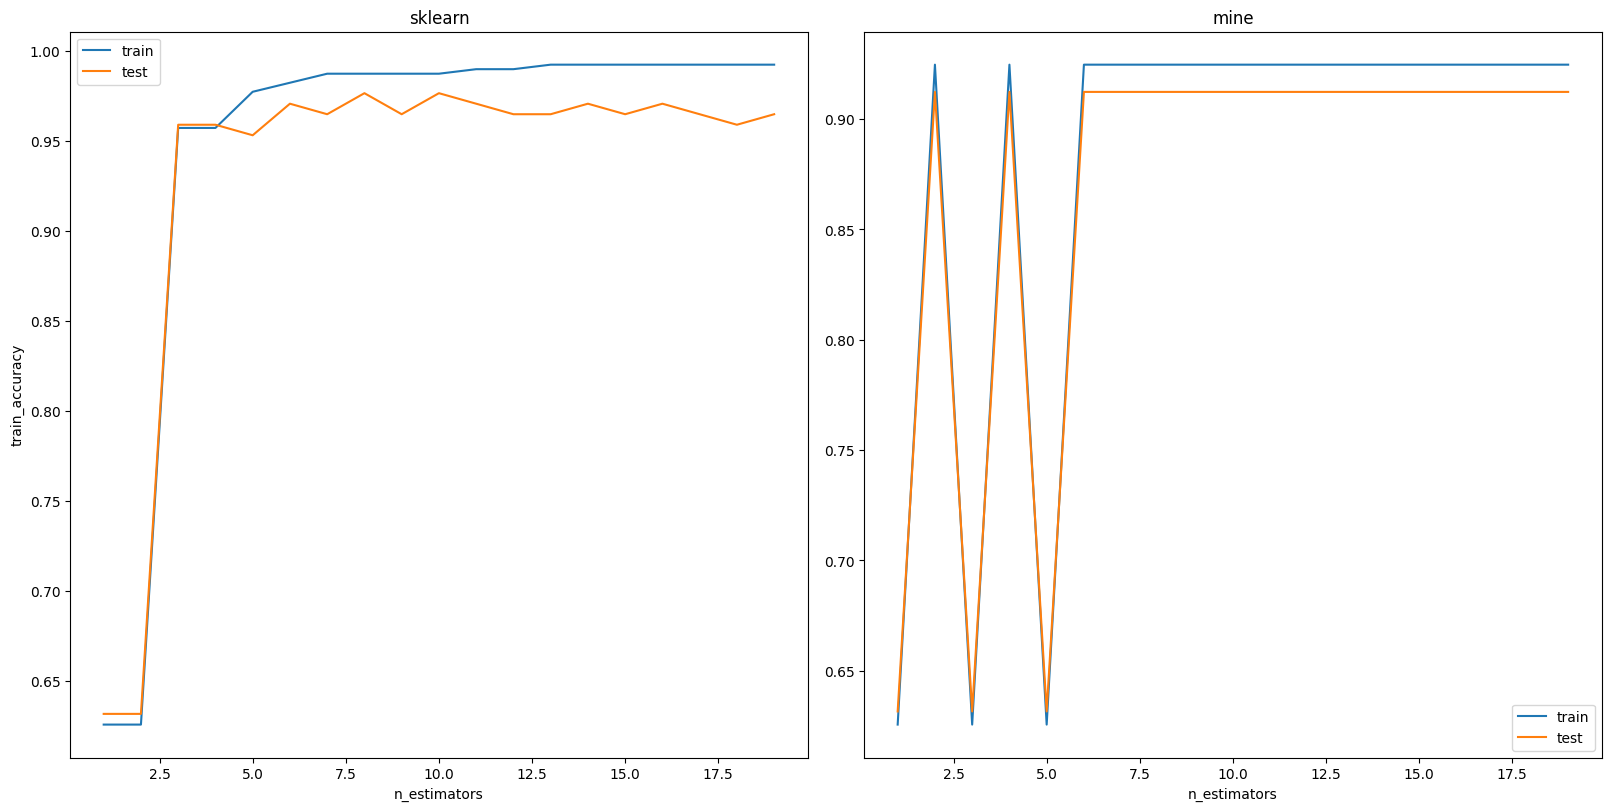

In [196]:
fig6, ax_arr = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
ax_arr[0].set_title("sklearn")
sns.lineplot(data=stat_lib, x="n_estimators", y="train_accuracy", ax=ax_arr[0], label="train")
sns.lineplot(data=stat_lib, x="n_estimators", y="test_accuracy", ax=ax_arr[0], label="test")

ax_arr[1].set_title("mine")
sns.lineplot(data=stat_my, x="n_estimators", y="train_accuracy", ax=ax_arr[1], label="train").set(ylabel=None)
sns.lineplot(data=stat_my, x="n_estimators", y="test_accuracy", ax=ax_arr[1], label="test").set(ylabel=None)